In [17]:
from astropy.table import Table, Column
import numpy as np
from numpy.linalg import inv 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
import urllib.request
import corner

In [18]:
os.chdir("/Users/Roberto Benard Orci/Documents/Python Scripts")
os.getcwd()

'C:\\Users\\Roberto Benard Orci\\Documents\\Python Scripts'

In [19]:
Table1 = np.loadtxt(fname = "/Users/Roberto Benard Orci/Documents/Python Scripts/Table1.txt")

column_names = ['ID', 'x', 'y','Sigma y', 'Sigma x', 'Rho xy']

#Table1 = pd.DataFrame(Table1, columns=column_names

In [20]:
b = 213.2734919759614
m = 1.0767475241683222

print(m,b)

1.0767475241683222 213.2734919759614


In [21]:
def f(t):
    return t*m +b

t3 = np.arange(0.0, 300.0, 0.1)
t4 = np.arange(0.0, 300.0, 0.02)

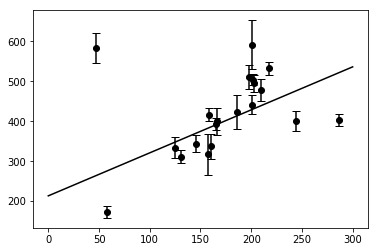

In [22]:
error = Table1[:,3]
plt.errorbar(Table1[:,1], Table1[:,2], yerr=error, fmt='ko',capsize=4)
plt.plot(t4, f(t4), 'k')

<ErrorbarContainer object of 3 artists>

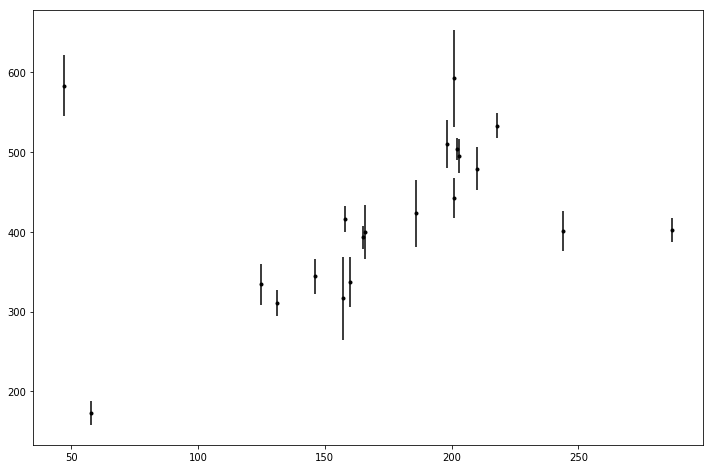

In [23]:
#np.size(Table1[:,0])                 # Numero de datos
#Table1[:,1]                          # x true
#b                                    # aplha "true"
#m                                    # beta_x "true"    
#np.mean(Table1[:,3])                 # eps true 
#Table1[:,2]                          # z obs
#f(t)                                 # z "true" 

m_true = m
b_true = b
N = np.size(Table1[:,0])

x = Table1[:,1]
yerr = Table1[:,3]
#y = m_true*x + b_true
y = Table1[:,2]

fig = plt.figure()
fig.set_size_inches(12, 8)
plt.errorbar(x, y, yerr=yerr, fmt='.k')

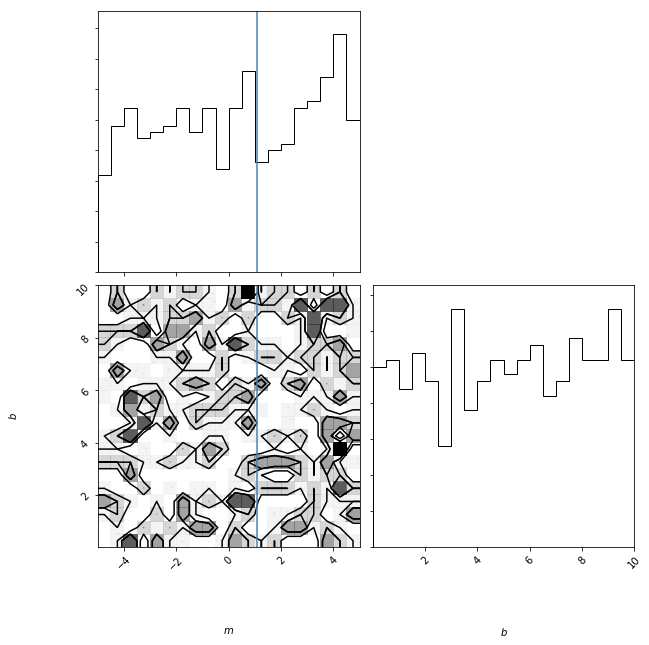

In [24]:
# Now, let's setup some parameters that define the MCMC
ndim = 2
nwalkers = 500

# Initialize the chain
# Choice 1: chain uniformly distributed in the range of the parameters
pos_min = np.array([-5., 0.])
pos_max = np.array([5., 10.])
psize = pos_max - pos_min
pos = [pos_min + psize*np.random.rand(ndim) for i in range(nwalkers)]

# Visualize the initialization

fig = corner.corner(pos, labels=["$m$", "$b$"], range=[[-5., 5.], [0., 10.]], 
                      truths=[m_true, b_true])
fig.set_size_inches(10,10)

In [25]:
# Define the posterior PDF
# Reminder: post_pdf(theta, data) = likelihood(data, theta) * prior_pdf(theta)
# We take the logarithm since emcee needs it.

# As prior, we assume an 'uniform' prior (i.e. constant prob. density)
def lnprior(theta):
    m, b = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0:
        return 0.0
    return -np.inf

# As likelihood, we assume the chi-square. Note: we do not even need to normalize it.
def lnlike(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    return -0.5*(np.sum( ((y-model)/yerr)**2. ))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [26]:
# Let us setup the emcee Ensemble Sampler
# It is very simple: just one, self-explanatory line
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [27]:
import time
time0 = time.time()
# burnin phase
pos, prob, state  = sampler.run_mcmc(pos, 300)
sampler.reset()
time1=time.time()
print(time1-time0)

1.3064236640930176


In [28]:
time0 = time.time()
# perform MCMC
pos, prob, state  = sampler.run_mcmc(pos, 700)
time1=time.time()
print(time1-time0)

samples = sampler.flatchain
samples.shape

2.9643540382385254


(350000, 2)

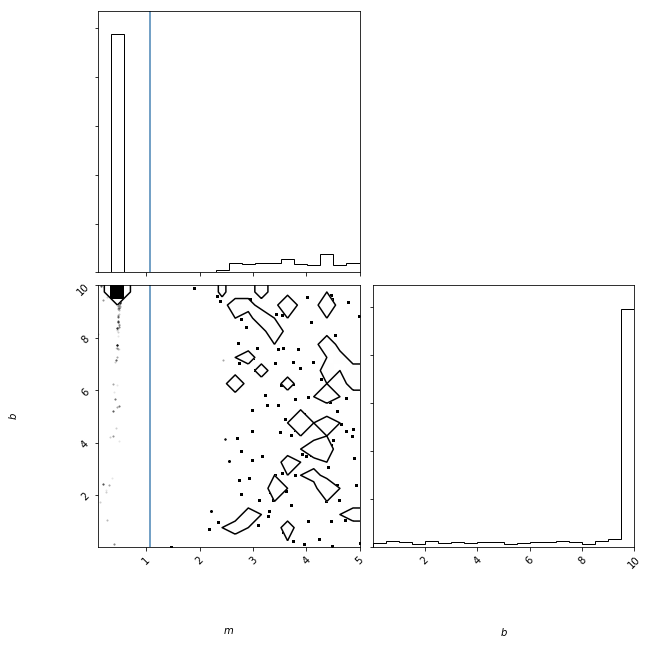

In [30]:
fig = corner.corner(samples, labels=["$m$", "$b$"],
                      truths=[m_true, b_true])
fig.set_size_inches(10,10)

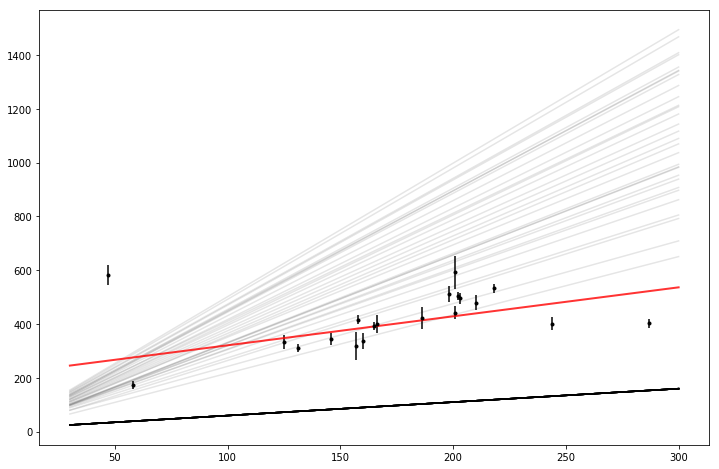

In [34]:
fig = plt.figure()

xl = np.array([30, 300])
for m, b in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")
fig.set_size_inches(12, 8)

(100, 600)

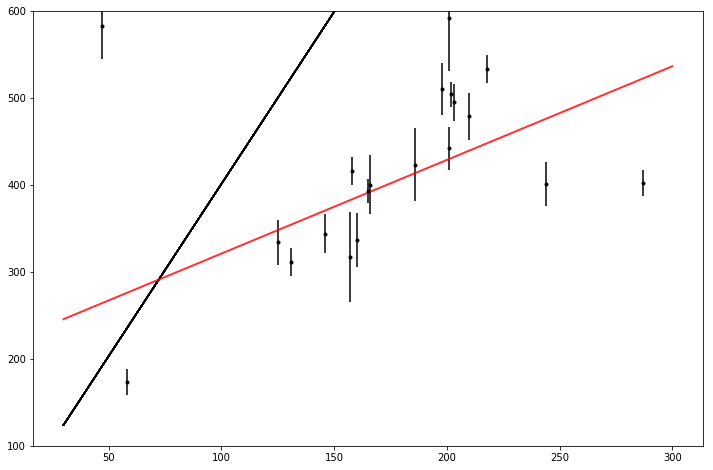

In [36]:
# Plot back the results in the space of data
fig = plt.figure()

xl = np.array([30, 300])
for m, b in samples[-100:]: # samples[np.random.randint(len(samples[-100), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")
fig.set_size_inches(12, 8)
plt.ylim(100,600)

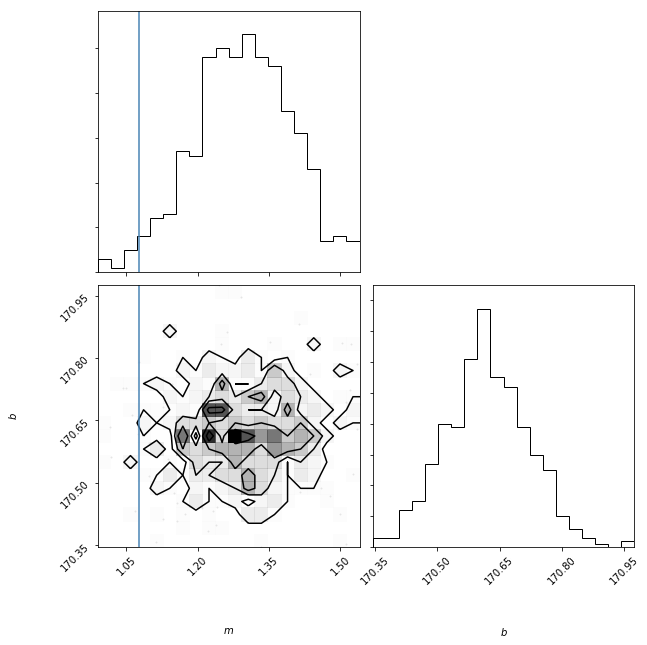

In [40]:
pos = [[m_true*1.2,b_true*0.8] + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] 

# Visualize the initialization
fig = corner.corner(pos, labels=["$m$", "$b$"],
                      truths=[m_true, b_true])
fig.set_size_inches(10,10)

1.6793465614318848


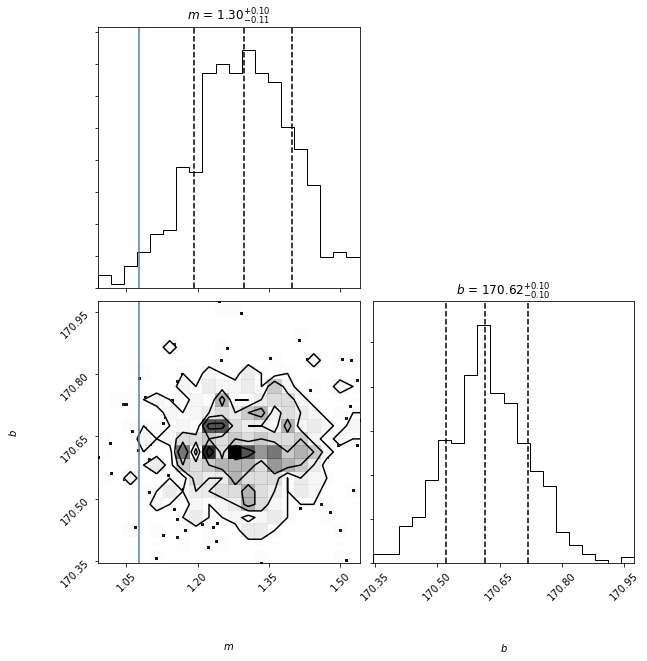

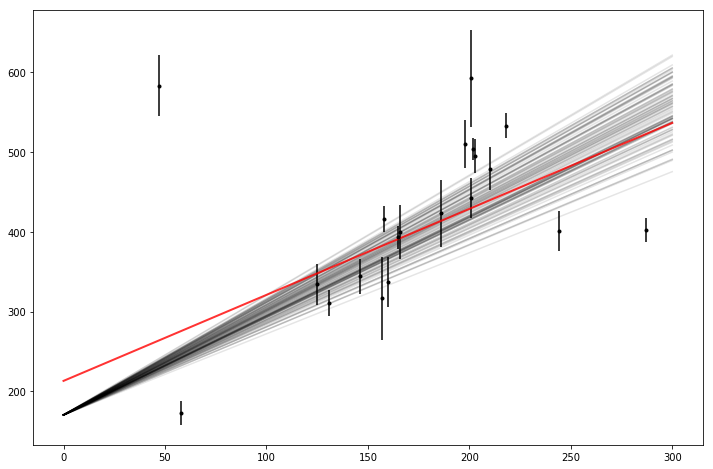

In [44]:
import time
time0 = time.time()
# burnin phase
pos, prob, state  = sampler.run_mcmc(pos, 300)
sampler.reset()
# perform MCMC
pos, prob, state  = sampler.run_mcmc(pos, 700)
time1=time.time()
print(time1-time0)

samples = sampler.flatchain
#let's plot the results
fig = corner.corner(samples, labels=["$m$", "$b$"],
                      truths=[m_true, b_true], quantiles=[0.16, 0.5, 0.84], show_titles=True, labels_args={"fontsize": 40})
fig.set_size_inches(10,10)
# Plot back the results in the space of data
fig = plt.figure()

xl = np.array([0, 300])
for m, b in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")
fig.set_size_inches(12, 8)